In [100]:
import pymc as pm
from scipy.stats import poisson
from itertools import product
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.stats import poisson
import sqlite3

df = pd.read_csv("shots.csv")

df["days_ago"] = (pd.to_datetime(df["match_date"]).max() - pd.to_datetime(df["match_date"])).dt.days

team_mapping = {
    "Brighton & Hove Albion": "Brighton",
    "West Ham United": "West Ham",
    "Wolverhampton Wanderers": "Wolves",
    "Tottenham Hotspur": "Tottenham",
    "Nottingham Forest": "Nott'ham Forest",
    "Manchester United": "Manchester Utd",
    "Newcastle United": "Newcastle Utd"
    }

df["Team"] = df["Team"].map(team_mapping).fillna(df["Team"])
df["home_team"] = df["home_team"].map(team_mapping).fillna(df["home_team"])
df["away_team"] = df["away_team"].map(team_mapping).fillna(df["away_team"])

df

,Minute,Team,Player,Event Type,Outcome,xG,PSxG,match_url,match_date,home_team,away_team,division,season,days_ago
0,3,Brighton,Simon Adingra,Shot,Off Target,0.03,0.00,https://fbref.com/en/matches/e4bb1c35/Tottenha...,2025-05-25,Tottenham,Brighton,Premier League,2024,0
1,3,Brighton,Diego Gómez,Goal,Goal,0.00,0.00,https://fbref.com/en/matches/e4bb1c35/Tottenha...,2025-05-25,Tottenham,Brighton,Premier League,2024,0
2,7,Tottenham,Mathys Tel,Shot,Blocked,0.04,0.00,https://fbref.com/en/matches/e4bb1c35/Tottenha...,2025-05-25,Tottenham,Brighton,Premier League,2024,0
3,10,Brighton,Mats Wieffer,Shot,Off Target,0.02,0.00,https://fbref.com/en/matches/e4bb1c35/Tottenha...,2025-05-25,Tottenham,Brighton,Premier League,2024,0
4,12,Brighton,Simon Adingra,Shot,Blocked,0.02,0.00,https://fbref.com/en/matches/e4bb1c35/Tottenha...,2025-05-25,Tottenham,Brighton,Premier League,2024,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12525,80,Manchester Utd,Bruno Fernandes,Shot,Saved,0.13,0.18,https://fbref.com/en/matches/cc5b4244/Manchest...,2024-08-16,Manchester Utd,Fulham,Premier League,2024,282
12526,87,Manchester Utd,Joshua Zirkzee,Shot,Goal,0.07,0.86,https://fbref.com/en/matches/cc5b4244/Manchest...,2024-08-16,Manchester Utd,Fulham,Premier League,2024,282
12527,87,Manchester Utd,Joshua Zirkzee,Goal,Goal,0.00,0.00,https://fbref.com/en/matches/cc5b4244/Manchest...,2024-08-16,Manchester Utd,Fulham,Premier League,2024,282
12528,90,Fulham,Calvin Bassey,Shot,Off Target,0.05,0.00,https://fbref.com/en/matches/cc5b4244/Manchest...,2024-08-16,Manchester Utd,Fulham,Premier League,2024,282


In [101]:
goals_df = df[df["Event Type"].isin(["Goal", "Own Goal", "Penalty"])]

# Create a complete match framework first
matches = df[['match_url', 'match_date', 'home_team', 'away_team', 'days_ago']].drop_duplicates()

# Count goals by team for each match (this will miss teams that scored 0)
team_goals = goals_df.groupby(['match_url', 'Team']).size().reset_index(name='goals')

# Merge with match info to identify home/away
team_goals = team_goals.merge(matches, on='match_url')

# Separate home and away goals
home_goals = team_goals[team_goals['Team'] == team_goals['home_team']].groupby('match_url')['goals'].sum().reset_index().rename(columns={'goals': 'home_goals'})
away_goals = team_goals[team_goals['Team'] == team_goals['away_team']].groupby('match_url')['goals'].sum().reset_index().rename(columns={'goals': 'away_goals'})

# Start with all matches and left join the goals (this ensures every match appears)
goals = matches.merge(home_goals, on='match_url', how='left').merge(away_goals, on='match_url', how='left')

# Fill NaN with 0 for teams that didn't score
goals['home_goals'] = goals['home_goals'].fillna(0).astype(int)
goals['away_goals'] = goals['away_goals'].fillna(0).astype(int)

goals

,match_url,match_date,home_team,away_team,days_ago,home_goals,away_goals
0,https://fbref.com/en/matches/e4bb1c35/Tottenha...,2025-05-25,Tottenham,Brighton,0,1,4
1,https://fbref.com/en/matches/1ff370e8/Bournemo...,2025-05-25,Bournemouth,Leicester City,0,2,0
2,https://fbref.com/en/matches/36844e73/Newcastl...,2025-05-25,Newcastle Utd,Everton,0,0,1
3,https://fbref.com/en/matches/3d22336e/Fulham-M...,2025-05-25,Fulham,Manchester City,0,0,2
4,https://fbref.com/en/matches/464cbad6/Nottingh...,2025-05-25,Nott'ham Forest,Chelsea,0,0,1
...,...,...,...,...,...,...,...
375,https://fbref.com/en/matches/4efc72e4/Nottingh...,2024-08-17,Nott'ham Forest,Bournemouth,281,1,1
376,https://fbref.com/en/matches/71618ace/Everton-...,2024-08-17,Everton,Brighton,281,0,3
377,https://fbref.com/en/matches/34557647/Newcastl...,2024-08-17,Newcastle Utd,Southampton,281,1,0
378,https://fbref.com/en/matches/a1d0d529/Ipswich-...,2024-08-17,Ipswich Town,Liverpool,281,0,2


In [102]:
goals["home_goals"].mean(),goals["away_goals"].mean()

(1.518421052631579, 1.4763157894736842)

In [103]:
shots_df = df[df["Event Type"].isin(["Shot", "Penalty"])]

shots_df["side"] = np.where(
    shots_df["Team"] == shots_df["home_team"], 
    "home",
    np.where(shots_df["Team"] == shots_df["away_team"], "away", "unknown")
)

shots = shots_df

shots

C:\Users\Owner\AppData\Local\Temp\ipykernel_7228\3328119158.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots_df["side"] = np.where(


,Minute,Team,Player,Event Type,Outcome,xG,PSxG,match_url,match_date,home_team,away_team,division,season,days_ago,side
0,3,Brighton,Simon Adingra,Shot,Off Target,0.03,0.00,https://fbref.com/en/matches/e4bb1c35/Tottenha...,2025-05-25,Tottenham,Brighton,Premier League,2024,0,away
2,7,Tottenham,Mathys Tel,Shot,Blocked,0.04,0.00,https://fbref.com/en/matches/e4bb1c35/Tottenha...,2025-05-25,Tottenham,Brighton,Premier League,2024,0,home
3,10,Brighton,Mats Wieffer,Shot,Off Target,0.02,0.00,https://fbref.com/en/matches/e4bb1c35/Tottenha...,2025-05-25,Tottenham,Brighton,Premier League,2024,0,away
4,12,Brighton,Simon Adingra,Shot,Blocked,0.02,0.00,https://fbref.com/en/matches/e4bb1c35/Tottenha...,2025-05-25,Tottenham,Brighton,Premier League,2024,0,away
5,17,Tottenham,Dominic Solanke(pen),Penalty,Goal,0.79,0.92,https://fbref.com/en/matches/e4bb1c35/Tottenha...,2025-05-25,Tottenham,Brighton,Premier League,2024,0,home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12524,76,Fulham,Calvin Bassey,Shot,Blocked,0.04,0.00,https://fbref.com/en/matches/cc5b4244/Manchest...,2024-08-16,Manchester Utd,Fulham,Premier League,2024,282,away
12525,80,Manchester Utd,Bruno Fernandes,Shot,Saved,0.13,0.18,https://fbref.com/en/matches/cc5b4244/Manchest...,2024-08-16,Manchester Utd,Fulham,Premier League,2024,282,home
12526,87,Manchester Utd,Joshua Zirkzee,Shot,Goal,0.07,0.86,https://fbref.com/en/matches/cc5b4244/Manchest...,2024-08-16,Manchester Utd,Fulham,Premier League,2024,282,home
12528,90,Fulham,Calvin Bassey,Shot,Off Target,0.05,0.00,https://fbref.com/en/matches/cc5b4244/Manchest...,2024-08-16,Manchester Utd,Fulham,Premier League,2024,282,away


In [104]:
def poisson_binomial_pmf(k, p_values):
    """
    Calculate PMF of Poisson-Binomial distribution for k successes
    given array of success probabilities p_values
    
    Uses dynamic programming approach for efficiency
    """
    n = len(p_values)
    if k > n or k < 0:
        return 0.0
    
    # Dynamic programming table
    # dp[i][j] = probability of exactly j successes using first i trials
    dp = np.zeros((n + 1, k + 1))
    dp[0][0] = 1.0  # Base case: 0 trials, 0 successes
    
    for i in range(1, n + 1):
        p = p_values[i - 1]
        dp[i][0] = dp[i - 1][0] * (1 - p)  # 0 successes
        
        for j in range(1, min(i, k) + 1):
            # j successes = (j successes from first i-1, no success on trial i) +
            #               (j-1 successes from first i-1, success on trial i)
            dp[i][j] = dp[i - 1][j] * (1 - p) + dp[i - 1][j - 1] * p
    
    return dp[n][k]

def simulate_shots_poisson_binomial(xg_values, max_goals=None):
    """
    Simulate goal probabilities using Poisson-Binomial distribution
    
    Args:
        xg_values: array of xG values for individual shots
        max_goals: maximum number of goals to consider (default: number of shots)
    
    Returns:
        dict with goals as keys and probabilities as values
    """
    if len(xg_values) == 0:
        return {0: 1.0}
    
    if max_goals is None:
        max_goals = len(xg_values)
    
    goal_probs = {}
    for goals in range(max_goals + 1):
        prob = poisson_binomial_pmf(goals, xg_values)
        if prob > 1e-10:  # Only keep non-negligible probabilities
            goal_probs[goals] = prob
    
    return goal_probs

def simulate_game_poisson_binomial(home_xg_shots, away_xg_shots, max_goals=9):
    """
    Simulate a game using Poisson-Binomial distribution for each team
    
    Args:
        home_xg_shots: array of xG values for home team shots
        away_xg_shots: array of xG values for away team shots
        max_goals: maximum goals to consider for each team
    
    Returns:
        list of dicts with home_goals, away_goals, and probability
    """
    home_probs = simulate_shots_poisson_binomial(home_xg_shots, max_goals)
    away_probs = simulate_shots_poisson_binomial(away_xg_shots, max_goals)
    
    game_probs = []
    for (h_goals, h_prob), (a_goals, a_prob) in product(home_probs.items(), away_probs.items()):
        combined_prob = h_prob * a_prob
        if combined_prob > 1e-6:  # Filter very small probabilities
            game_probs.append({
                'home_goals': h_goals,
                'away_goals': a_goals,
                'probability': combined_prob
            })
    
    return game_probs

def create_weighted_scoreline_data_poisson_binomial(
    df, 
    shot_data, 
    max_goals=9, 
    min_prob_threshold=0.001,
    decay_rate=0.001,
    goals_weight=0.2,
    xg_weight=0.5,
    psxg_weight=0.3
):
    """
    Create expanded dataset with all possible scorelines using both Poisson-Binomial 
    and Poisson distributions for comparison
    """
    expanded_data = []
    
    for idx, row in df.iterrows():
        match_id = row['match_url']
        
        # Get shot data for this match
        match_shots = shot_data[shot_data['match_url'].str.replace(":tab=stats", "") == match_id]
        
        if match_shots.empty:
            print(f"Warning: No shot data found for match_id {match_id}")
            continue
            
        home_xg_shots = match_shots[match_shots['side'] == 'home']['xG'].values
        away_xg_shots = match_shots[match_shots['side'] == 'away']['xG'].values

        home_psxg_shots = match_shots[match_shots['side'] == 'home']['PSxG'].values
        away_psxg_shots = match_shots[match_shots['side'] == 'away']['PSxG'].values
        
        # Calculate total xG for each team
        home_total_xg = home_xg_shots.sum()
        away_total_xg = away_xg_shots.sum()
        
        # Generate scorelines with Poisson-Binomial (individual shots)
        xg_game_probs_pb = simulate_game_poisson_binomial(home_xg_shots, away_xg_shots, max_goals)
        psxg_game_probs_pb = simulate_game_poisson_binomial(home_psxg_shots, away_psxg_shots, max_goals)
        
        # Generate scorelines with regular Poisson (total xG)
        home_total_xg_probs = {i: poisson.pmf(i, home_total_xg) for i in range(max_goals + 1)}
        away_total_xg_probs = {i: poisson.pmf(i, away_total_xg) for i in range(max_goals + 1)}
        
        # Create lookup for Poisson-Binomial probabilities
        xg_pb_prob_lookup = {(sp['home_goals'], sp['away_goals']): sp['probability'] 
                         for sp in xg_game_probs_pb}
        psxg_pb_prob_lookup = {(sp['home_goals'], sp['away_goals']): sp['probability'] 
                         for sp in psxg_game_probs_pb}
        
        # Get actual scoreline
        actual_home = int(row['home_goals'])
        actual_away = int(row['away_goals'])
        
        # Store match scorelines temporarily
        match_scorelines = []
        
        # Iterate through all possible scorelines
        for home_goals in range(max_goals + 1):
            for away_goals in range(max_goals + 1):
                
                # Get probabilities from both methods
                xg_pb_prob = xg_pb_prob_lookup.get((home_goals, away_goals), 0.0)
                psxg_pb_prob = psxg_pb_prob_lookup.get((home_goals, away_goals), 0.0)
                xg_total_poisson_prob = home_total_xg_probs[home_goals] * away_total_xg_probs[away_goals]
                
                # Skip if all probabilities are negligible
                if xg_pb_prob < 1e-10 and xg_total_poisson_prob < 1e-10 and psxg_pb_prob < 1e-10:
                    continue
                
                # Check if this is the actual scoreline
                is_actual = (home_goals == actual_home and away_goals == actual_away)
                
                match_scorelines.append({
                    'match_id': match_id,
                    'home_team': row['home_team'],
                    'away_team': row['away_team'],
                    'home_goals': home_goals,
                    'away_goals': away_goals,
                    'days_ago': row['days_ago'],
                    'is_actual': is_actual,
                    'xg_pb_prob_raw': xg_pb_prob,
                    'psxg_pb_prob_raw': psxg_pb_prob,
                    'xg_total_poisson_prob_raw': xg_total_poisson_prob,
                })
        
        if not match_scorelines:
            continue
            
        # Filter by minimum probability threshold BEFORE normalization
        filtered_scorelines = []
        for scoreline in match_scorelines:
            # Use a simple threshold on raw probabilities or keep actual scoreline
            if (scoreline['xg_pb_prob_raw'] >= min_prob_threshold or 
                scoreline['psxg_pb_prob_raw'] >= min_prob_threshold or 
                scoreline['xg_total_poisson_prob_raw'] >= min_prob_threshold or 
                scoreline['is_actual']):
                filtered_scorelines.append(scoreline)
        
        # NOW normalize probabilities within the filtered set
        total_xg_pb_prob = sum(s['xg_pb_prob_raw'] for s in filtered_scorelines)
        total_psxg_pb_prob = sum(s['psxg_pb_prob_raw'] for s in filtered_scorelines)
        total_xg_total_poisson_prob = sum(s['xg_total_poisson_prob_raw'] for s in filtered_scorelines)
        
        for scoreline in filtered_scorelines:
            scoreline['poisson_binomial_xg_prob'] = scoreline['xg_pb_prob_raw'] / total_xg_pb_prob if total_xg_pb_prob > 0 else 0
            scoreline['poisson_binomial_psxg_prob'] = scoreline['psxg_pb_prob_raw'] / total_psxg_pb_prob if total_psxg_pb_prob > 0 else 0
            scoreline['poisson_xg_total_prob'] = scoreline['xg_total_poisson_prob_raw'] / total_xg_total_poisson_prob if total_xg_total_poisson_prob > 0 else 0
        
        # Calculate remaining weight after actual scoreline boost
        remaining_weight = 1.0 - goals_weight
        
        # Apply weighting and store current match data
        current_match_data = []
        for scoreline in filtered_scorelines:
            normalized_pb_xg_prob = scoreline['poisson_binomial_xg_prob']
            normalized_pb_psxg_prob = scoreline["poisson_binomial_psxg_prob"]
            normalized_p_xg_total_prob = scoreline["poisson_xg_total_prob"]
            
            # Calculate weights (using goals_weight as boost for actual scorelines)
            if scoreline['is_actual']:
                # Actual scoreline gets goals_weight as boost
                final_weight = goals_weight + (remaining_weight * (
                    xg_weight * normalized_p_xg_total_prob + 
                    psxg_weight * normalized_pb_psxg_prob
                ))
            else:
                # Non-actual scorelines get weighted probability without boost
                final_weight = remaining_weight * (
                    xg_weight * normalized_p_xg_total_prob + 
                    psxg_weight * normalized_pb_psxg_prob
                )
            
            current_match_data.append({
                'match_id': scoreline['match_id'],
                'home_team': scoreline['home_team'],
                'away_team': scoreline['away_team'],
                'home_goals': scoreline['home_goals'],
                'away_goals': scoreline['away_goals'],
                'weight': final_weight,
                'days_ago': scoreline['days_ago'],
                'is_actual': scoreline['is_actual'],
                'poisson_binomial_xg_prob': normalized_pb_xg_prob,
                'poisson_binomial_psxg_prob': normalized_pb_psxg_prob,
                'poisson_xg_total_prob': normalized_p_xg_total_prob
            })
        
        # Normalize weights so they sum to 1 for this match (BEFORE time decay)
        total_weight_for_match = sum(s['weight'] for s in current_match_data)
        if total_weight_for_match > 0:
            for s in current_match_data:
                s['weight'] = s['weight'] / total_weight_for_match
        
        # NOW apply time decay to the entire match
        time_weight = np.exp(-decay_rate * row['days_ago'])
        for s in current_match_data:
            s['weight'] = s['weight'] * time_weight
        
        # Add to expanded_data
        expanded_data.extend(current_match_data)
    
    return pd.DataFrame(expanded_data)

# Example usage:

# With shot-level data:
df = create_weighted_scoreline_data_poisson_binomial(
    goals, 
    shots,
    max_goals=9,
    decay_rate=0.001,
    goals_weight=0.2,
    xg_weight=0.5,
    psxg_weight=0.3
)

df

,match_id,home_team,away_team,home_goals,away_goals,weight,days_ago,is_actual,poisson_binomial_xg_prob,poisson_binomial_psxg_prob,poisson_xg_total_prob
0,https://fbref.com/en/matches/e4bb1c35/Tottenha...,Tottenham,Brighton,0,0,0.006593,0,False,0.001302,0.000014,0.013838
1,https://fbref.com/en/matches/e4bb1c35/Tottenha...,Tottenham,Brighton,0,1,0.014911,0,False,0.007230,0.000296,0.031135
2,https://fbref.com/en/matches/e4bb1c35/Tottenha...,Tottenham,Brighton,0,2,0.017270,0,False,0.010548,0.002067,0.035027
3,https://fbref.com/en/matches/e4bb1c35/Tottenha...,Tottenham,Brighton,0,3,0.014365,0,False,0.007430,0.006495,0.026270
4,https://fbref.com/en/matches/e4bb1c35/Tottenha...,Tottenham,Brighton,0,4,0.009901,0,False,0.003181,0.010027,0.014777
...,...,...,...,...,...,...,...,...,...,...,...
12321,https://fbref.com/en/matches/cc5b4244/Manchest...,Manchester Utd,Fulham,6,1,0.002614,282,False,0.001687,0.000000,0.007278
12322,https://fbref.com/en/matches/cc5b4244/Manchest...,Manchester Utd,Fulham,6,2,0.000575,282,False,0.000347,0.000000,0.001601
12323,https://fbref.com/en/matches/cc5b4244/Manchest...,Manchester Utd,Fulham,7,0,0.002071,282,False,0.000407,0.000000,0.005765
12324,https://fbref.com/en/matches/cc5b4244/Manchest...,Manchester Utd,Fulham,7,1,0.000911,282,False,0.000188,0.000000,0.002537


In [105]:
df.groupby(["match_id", "days_ago"])["weight"].sum().reset_index().sort_values(by="days_ago")

,match_id,days_ago,weight
0,https://fbref.com/en/matches/01d155b4/Southamp...,0,1.000000
33,https://fbref.com/en/matches/15559cff/Ipswich-...,0,1.000000
183,https://fbref.com/en/matches/7ea43929/Manchest...,0,1.000000
186,https://fbref.com/en/matches/812ef8ad/Wolverha...,0,1.000000
15,https://fbref.com/en/matches/0958eb7a/Liverpoo...,0,1.000000
...,...,...,...
162,https://fbref.com/en/matches/71618ace/Everton-...,281,0.755028
117,https://fbref.com/en/matches/4efc72e4/Nottingh...,281,0.755028
233,https://fbref.com/en/matches/a1d0d529/Ipswich-...,281,0.755028
277,https://fbref.com/en/matches/c0e3342a/Arsenal-...,281,0.755028


In [106]:
teams = df["home_team"].unique()
n_teams = len(teams)
home_idx = pd.Categorical(df["home_team"], categories=teams).codes
away_idx = pd.Categorical(df["away_team"], categories=teams).codes


home_goals_obs = df["home_goals"]
away_goals_obs = df["away_goals"]

In [107]:
with pm.Model() as model:
    att_str_raw = pm.Normal("att_str_raw", mu=0, sigma=1, shape=n_teams)
    def_str_raw = pm.Normal("def_str_raw", mu=0, sigma=1, shape=n_teams)
     
    att_str = pm.Deterministic("att_str", att_str_raw - pm.math.mean(att_str_raw))
    def_str = pm.Deterministic("def_str", def_str_raw - pm.math.mean(def_str_raw))
    
    home_adv = pm.Gamma("home_adv", alpha=4, beta=4/0.128)

    baseline = pm.Normal("baseline", mu=np.log(1.476), sigma=0.1)

    home_goals_mu = pm.math.exp(baseline + att_str[home_idx] + def_str[away_idx] + home_adv)
    away_goals_mu = pm.math.exp(baseline + att_str[away_idx] + def_str[home_idx])

    weights = pm.ConstantData("weights", df["weight"].values)
    
    home_logp = pm.logp(pm.Poisson.dist(mu=home_goals_mu), home_goals_obs)
    away_logp = pm.logp(pm.Poisson.dist(mu=away_goals_mu), away_goals_obs)

    pm.Potential("weighted_home_goals", pm.math.sum(weights * home_logp))
    pm.Potential("weighted_away_goals", pm.math.sum(weights * away_logp))

    trace = pm.sample(5000, tune=2500, cores=4, nuts_sampler='blackjax', return_inferencedata=True)

c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\sampling\jax.py:368: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
att_str_raw[0],0.117,0.258,-0.372,0.595,0.008,0.006,984.0,2704.0,1.0
att_str_raw[1],0.151,0.258,-0.330,0.637,0.008,0.006,981.0,2644.0,1.0
att_str_raw[2],0.213,0.255,-0.285,0.670,0.008,0.006,939.0,2502.0,1.0
att_str_raw[3],-0.024,0.261,-0.508,0.460,0.008,0.006,975.0,2607.0,1.0
att_str_raw[4],-0.050,0.264,-0.548,0.436,0.008,0.006,1038.0,2857.0,1.0
...,...,...,...,...,...,...,...,...,...
def_str[15],0.013,0.142,-0.245,0.285,0.001,0.001,36654.0,14269.0,1.0
def_str[16],0.092,0.133,-0.152,0.349,0.001,0.001,40500.0,15262.0,1.0
def_str[17],-0.137,0.148,-0.429,0.124,0.001,0.001,34469.0,15296.0,1.0
def_str[18],-0.140,0.151,-0.426,0.139,0.001,0.001,33881.0,15354.0,1.0


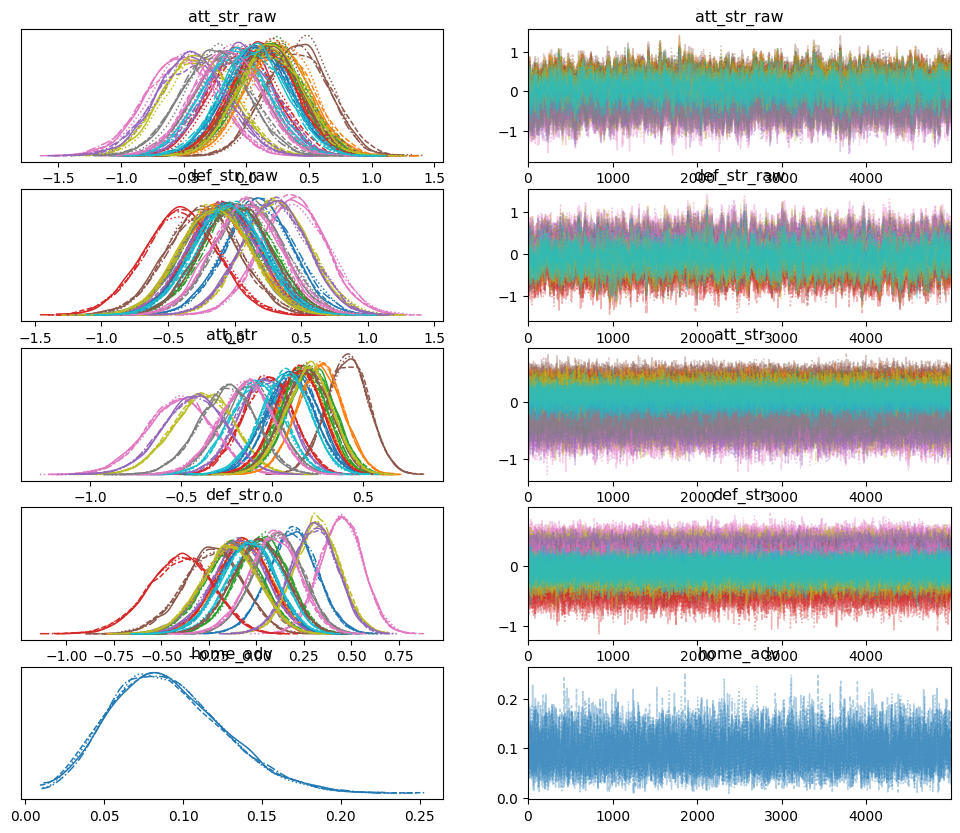

In [108]:
# Summary statistics for all parameters
az.summary(trace)

# Trace plots for all parameters
az.plot_trace(trace, var_names=[
    "att_str_raw", 
    "def_str_raw", 
    "att_str",     
    "def_str",            
    "home_adv"
])


az.summary(trace)

In [109]:

# Get team rankings
att_summary = az.summary(trace, var_names=["att_str"])
att_summary.index = teams
print("Attack Strength Rankings:")
print(att_summary[['mean', 'hdi_3%', 'hdi_97%']].sort_values("mean", ascending=False))

def_summary = az.summary(trace, var_names=["def_str"]) 
def_summary.index = teams
print("\nDefense Strength Rankings (lower is better):")
print(def_summary[['mean', 'hdi_3%', 'hdi_97%']].sort_values("mean", ascending=True))



Attack Strength Rankings:
                  mean  hdi_3%  hdi_97%
Liverpool        0.412   0.181    0.625
Manchester City  0.260   0.024    0.493
Newcastle Utd    0.213  -0.035    0.447
Chelsea          0.201  -0.047    0.439
Brentford        0.188  -0.058    0.431
Brighton         0.169  -0.077    0.407
Bournemouth      0.150  -0.092    0.406
Arsenal          0.143  -0.104    0.382
Tottenham        0.117  -0.132    0.373
Crystal Palace   0.091  -0.168    0.350
Aston Villa      0.072  -0.186    0.321
Fulham          -0.024  -0.297    0.228
Nott'ham Forest -0.051  -0.316    0.218
Manchester Utd  -0.091  -0.367    0.185
Wolves          -0.129  -0.407    0.158
West Ham        -0.146  -0.435    0.130
Everton         -0.248  -0.540    0.051
Ipswich Town    -0.381  -0.708   -0.075
Leicester City  -0.432  -0.762   -0.115
Southampton     -0.514  -0.858   -0.179

Defense Strength Rankings (lower is better):
                  mean  hdi_3%  hdi_97%
Arsenal         -0.401  -0.724   -0.086
Liverpoo

In [112]:
import numpy as np

# With sum-to-zero constraints, league average is simply 0
att_league_avg = 0.0
def_league_avg = 0.0
home_adv_mean = az.summary(trace, var_names=["home_adv"])['mean'].iloc[0]
baseline_mean = az.summary(trace, var_names=["baseline"])['mean'].iloc[0]

print(home_adv_mean)


def convert_to_expected_goals_constrained(att_summary, def_summary, baseline, home_adv):
    results = []
    
    for team in teams:
        team_att = att_summary.loc[team, 'mean']
        team_def = def_summary.loc[team, 'mean']
        
        # Expected goals FOR this team vs league average opponent
        goals_for = np.exp(baseline + team_att + def_league_avg)
        
        # Expected goals AGAINST this team vs league average opponent  
        goals_against = np.exp(baseline + att_league_avg + team_def)
        
        results.append({
            'Team': team,
            'Goals_For': goals_for,
            'Goals_Against': goals_against,
            'Goal_Diff': goals_for - goals_against
        })
    
    return pd.DataFrame(results)

# Create the conversion
goals_df = convert_to_expected_goals_constrained(att_summary, def_summary, baseline_mean, home_adv_mean)

print("\nExpected Goals vs League Average Team:")
print(goals_df[['Team', 'Goals_For', 'Goals_Against', 'Goal_Diff']].sort_values('Goal_Diff', ascending=False))

print(goals_df["Goals_For"].sum())
print(goals_df["Goals_Against"].sum())

0.09

Expected Goals vs League Average Team:
               Team  Goals_For  Goals_Against  Goal_Diff
5         Liverpool   1.985757       1.041852   0.943904
13          Arsenal   1.517403       0.880734   0.636669
11  Manchester City   1.705742       1.146828   0.558913
2     Newcastle Utd   1.627427       1.161834   0.465592
18          Chelsea   1.608014       1.143393   0.464621
1       Bournemouth   1.528062       1.226298   0.301763
15        Brentford   1.587245       1.332424   0.254821
12         Brighton   1.557372       1.352561   0.204811
10   Crystal Palace   1.440514       1.249821   0.190693
19      Aston Villa   1.413403       1.258600   0.154803
3            Fulham   1.284025       1.217744   0.066281
4   Nott'ham Forest   1.249821       1.203218   0.046602
0         Tottenham   1.478459       1.590423  -0.111964
9    Manchester Utd   1.200814       1.313900  -0.113086
17          Everton   1.026341       1.146828  -0.120487
16         West Ham   1.136553       1.4419